In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import random
import lime
from lime import lime_image
import shap


import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Classes: ['Grapes Disease Dataset test', 'Grapes Disease Dataset train', 'Grapes Disease Dataset validate']


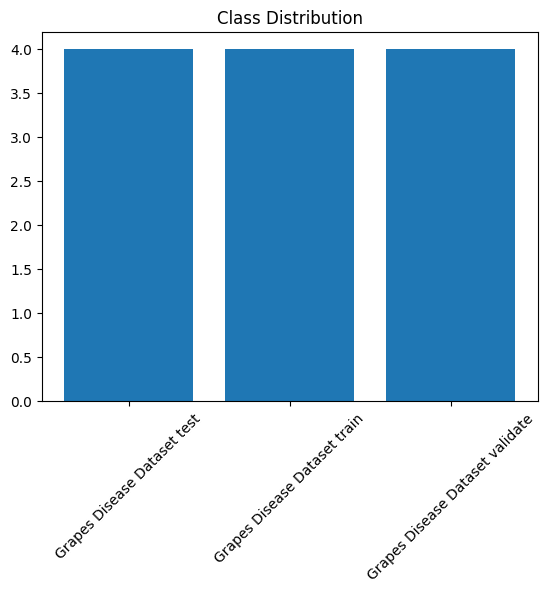

In [11]:
data_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)"  # class folders inside
classes = os.listdir(data_path)
print("Classes:", classes)

class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in classes}
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [12]:
# Paths
train_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
val_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
test_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"

In [13]:
import os

def count_images_per_class(base_dir):
    class_counts = {}
    total_images = 0

    if not os.path.exists(base_dir):
        print(f"❌ Directory not found: {base_dir}")
        return class_counts, total_images

    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[class_name] = image_count
            total_images += image_count

    return class_counts, total_images


train_counts, train_total = count_images_per_class(train_path)
val_counts, val_total = count_images_per_class(val_path)
test_counts, test_total = count_images_per_class(test_path)

# ✅ Print Results
def print_counts(title, counts, total):
    print(f"\n📁 {title} Set:")
    for cls, count in counts.items():
        print(f"  - {cls}: {count} images")
    print(f"🔢 Total images in {title.lower()} set: {total}")

print_counts("Train", train_counts, train_total)
print_counts("Validation", val_counts, val_total)
print_counts("Test", test_counts, test_total)

# ✅ Grand Total
grand_total = train_total + val_total + test_total
print(f"\n🧮 Grand Total Images: {grand_total}")


📁 Train Set:
  - Powdery Mildew: 284 images
  - Bacterial Leaf Spot: 70 images
  - Downy Mildew: 676 images
  - Healthy Leaves: 878 images
🔢 Total images in train set: 1908

📁 Validation Set:
  - Powdery Mildew: 61 images
  - Bacterial Leaf Spot: 15 images
  - Downy Mildew: 145 images
  - Healthy Leaves: 188 images
🔢 Total images in validation set: 409

📁 Test Set:
  - Powdery Mildew: 61 images
  - Bacterial Leaf Spot: 15 images
  - Downy Mildew: 145 images
  - Healthy Leaves: 188 images
🔢 Total images in test set: 409

🧮 Grand Total Images: 2726


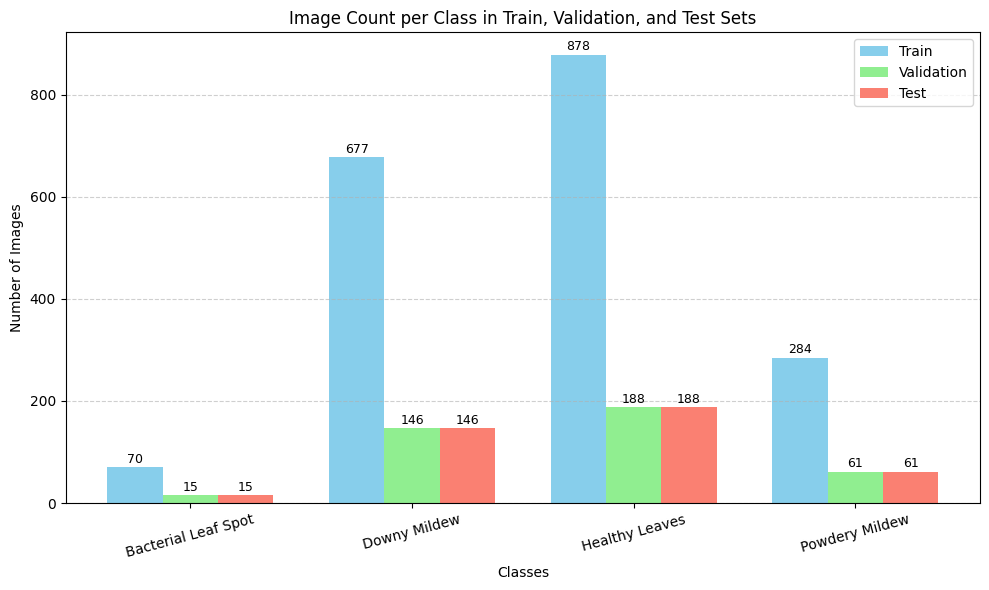

In [50]:
import os
import matplotlib.pyplot as plt
import numpy as np



# === Step 2: Get class names from train folder ===
classes = sorted(os.listdir(train_path))  # assumes same class folders in all splits

# === Step 3: Count images per class ===
def count_images(path, class_names):
    return [len(os.listdir(os.path.join(path, cls))) for cls in class_names]

train_counts = count_images(train_path, classes)
val_counts = count_images(val_path, classes)
test_counts = count_images(test_path, classes)

# === Step 4: Bar chart ===
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width, train_counts, width, label='Train', color='skyblue')
bars2 = plt.bar(x, val_counts, width, label='Validation', color='lightgreen')
bars3 = plt.bar(x + width, test_counts, width, label='Test', color='salmon')

# Add count labels on top
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 3, str(height),
                 ha='center', va='bottom', fontsize=9)

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Image Count per Class in Train, Validation, and Test Sets')
plt.xticks(x, classes, rotation=15)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [52]:
import os
import cv2
import numpy as np

# === Set Image Size ===
IMG_SIZE = 224

# === Define Root Paths ===
data_root = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)"

# === Get Class Names from Train Directory ===
classes = sorted(os.listdir(train_path))  # assuming all sets have same class folders
print("✅ Classes found:", classes)

# === Image Loader Function ===
def load_images_from_path(data_path, class_names):
    images = []
    labels = []

    for cls in class_names:
        cls_path = os.path.join(data_path, cls)
        if not os.path.exists(cls_path):
            print(f"⚠️ Skipping missing folder: {cls_path}")
            continue

        for fname in os.listdir(cls_path):
            img_path = os.path.join(cls_path, fname)

            # Skip directories and unsupported file types
            if os.path.isdir(img_path) or not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"❌ Skipping unreadable image: {img_path}")
                    continue

                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img.astype(np.float32) / 255.0

                images.append(img)
                labels.append(cls)

            except Exception as e:
                print(f"❌ Error loading {img_path}: {e}")
                continue

    return np.array(images), np.array(labels)

# === Load Train, Validation, and Test Data ===
train_images, train_labels = load_images_from_path(train_path, classes)
val_images, val_labels = load_images_from_path(val_path, classes)
test_images, test_labels = load_images_from_path(test_path, classes)

# === Final Output Shapes ===
print("✅ Train images shape:", train_images.shape)
print("✅ Train labels shape:", train_labels.shape)

print("✅ Validation images shape:", val_images.shape)
print("✅ Validation labels shape:", val_labels.shape)

print("✅ Test images shape:", test_images.shape)
print("✅ Test labels shape:", test_labels.shape)


✅ Classes found: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']
✅ Train images shape: (1908, 224, 224, 3)
✅ Train labels shape: (1908,)
✅ Validation images shape: (409, 224, 224, 3)
✅ Validation labels shape: (409,)
✅ Test images shape: (409, 224, 224, 3)
✅ Test labels shape: (409,)


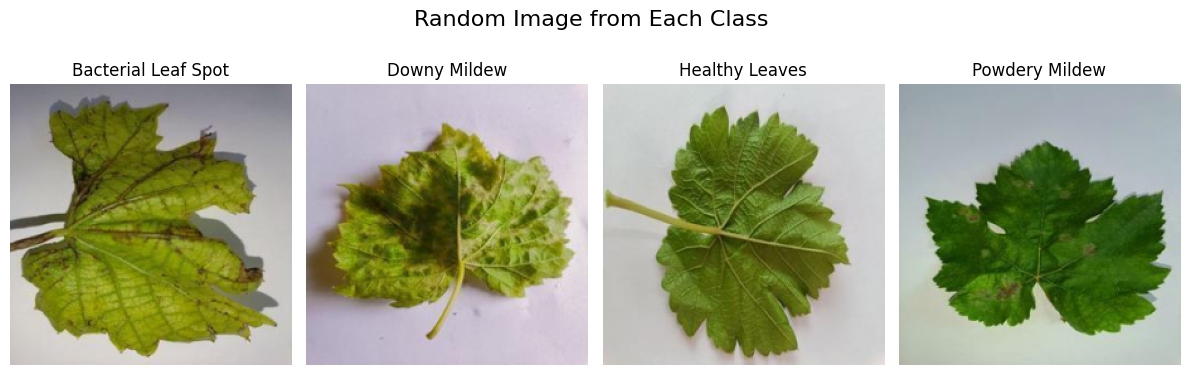

In [16]:
# === Simple preprocessing (just resize and normalize) ===
def preprocess_image_simple(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")
    img = cv2.resize(img, (224, 224))
    return img

def show_random_images_per_class(dataset_path):
    class_names = sorted(os.listdir(dataset_path))[:4]  # Only 4 classes
    plt.figure(figsize=(12, 4))
    
    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        image_path = random.choice(glob(os.path.join(class_folder, "*")))

        try:
            img = preprocess_image_simple(image_path)
        except Exception as e:
            print(f"⚠️ Error loading image: {e}")
            continue

        plt.subplot(1, 4, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(class_name)
        plt.axis('off')

    plt.suptitle("Random Image from Each Class ", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# === Run it ===
show_random_images_per_class(train_path)

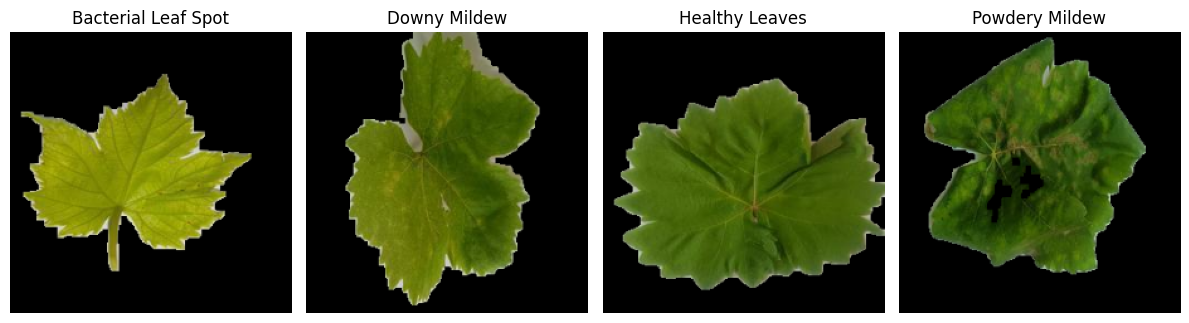

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob

#  Background removal using HSV + black background
def remove_leaf_background_black(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define mask range for green leaves
    lower = np.array([25, 40, 40])
    upper = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # Clean the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Apply black background
    result = cv2.bitwise_and(img, img, mask=mask)
    background = np.zeros_like(img)
    final = np.where(mask[:, :, None] == 255, result, background)

    return final

#  Show 1 random processed image per class
def show_random_images_per_class(root_path):
    class_dirs = sorted(os.listdir(root_path))
    plt.figure(figsize=(12, 4))
    
    for i, class_name in enumerate(class_dirs[:4]):  # Just 4 classes
        class_path = os.path.join(root_path, class_name)
        img_path = random.choice(glob(os.path.join(class_path, '*')))
        
        result = remove_leaf_background_black(img_path)
        result = cv2.resize(result, (224, 224))

        plt.subplot(1, 4, i + 1)
        plt.imshow(result)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 🔍 Dataset folder path
train_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"

#  Show the processed images
show_random_images_per_class(train_path)

In [18]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_aug.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1908 images belonging to 4 classes.
Found 409 images belonging to 4 classes.


In [19]:
# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
I0000 00:00:1752599848.700185      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752599848.701088      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20


I0000 00:00:1752599854.693434     117 service.cc:148] XLA service 0x7857740061c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752599854.695461     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752599854.695484     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752599855.115074     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/60 ━━━━━━━━━━━━━━━━━━━━ 9:10 9s/step - accuracy: 0.0938 - loss: 1.4018

I0000 00:00:1752599860.984344     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 663ms/step - accuracy: 0.4643 - loss: 1.3004 - val_accuracy: 0.6870 - val_loss: 0.7830
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - accuracy: 0.7098 - loss: 0.7593 - val_accuracy: 0.7164 - val_loss: 0.6957
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - accuracy: 0.7341 - loss: 0.7114 - val_accuracy: 0.7237 - val_loss: 0.6820
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 450ms/step - accuracy: 0.7746 - loss: 0.6033 - val_accuracy: 0.7824 - val_loss: 0.5529
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - accuracy: 0.7767 - loss: 0.5534 - val_accuracy: 0.7531 - val_loss: 0.6126
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 448ms/step - accuracy: 0.7817 - loss: 0.5679 - val_accuracy: 0.8313 - val_loss: 0.4946
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - accuracy: 0.8058 - loss: 0.5095 - val_accuracy: 0.8802 - val_loss: 0.3984
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 452ms/step - accuracy: 0.8400 - loss: 0.4331 - val_accuracy: 0.843

Found 409 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step
Accuracy:  0.8900
Precision: 0.8759
Recall:    0.8476
F1-Score:  0.8580

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.92      0.73      0.81        15
       Downy Mildew       0.87      0.94      0.90       145
     Healthy Leaves       0.96      0.88      0.92       188
     Powdery Mildew       0.76      0.84      0.80        61

           accuracy                           0.89       409
          macro avg       0.88      0.85      0.86       409
       weighted avg       0.90      0.89      0.89       409



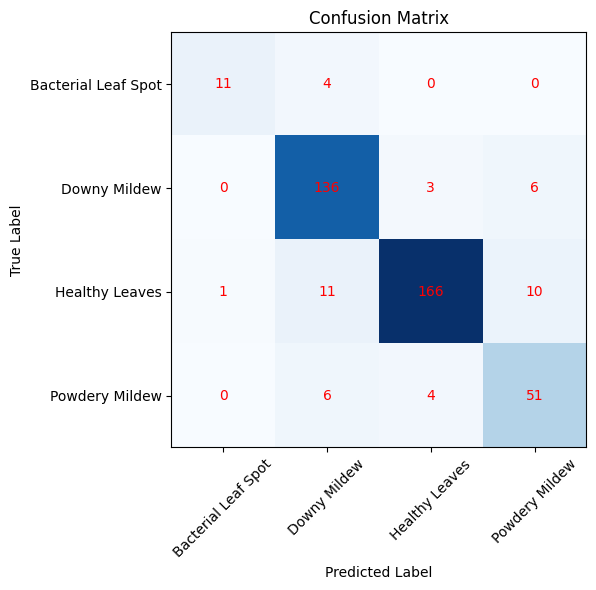

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model  # Optional if loading a saved model

# Step 1: Load test data using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test',       # 🔁 Replace with actual test data path
    target_size=(224, 224),    # 🔁 Adjust to match your model input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False              # ⚠️ Do not shuffle for correct label alignment
)

# Optional: load your model if not already in memory
# model = load_model('your_model.h5')

# Step 2: Predict on test data
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Calculate evaluation metrics
accuracy = np.mean(y_true == y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Step 4: Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Step 5: Classification Report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Optional: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()


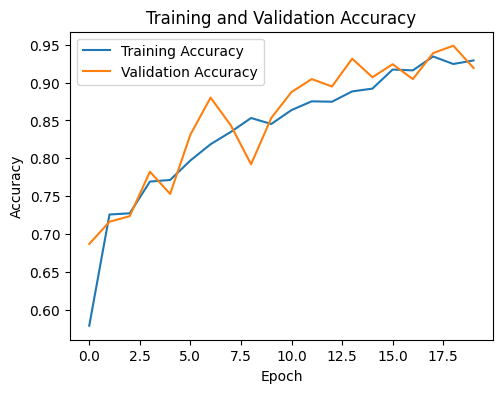

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

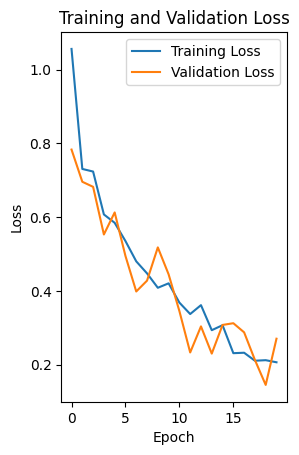

In [22]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Step 1: Paths ===
train_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
val_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
test_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"

# === Step 2: Data Generators ===
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_aug.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_aug.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1908 images belonging to 4 classes.
Found 409 images belonging to 4 classes.
Found 409 images belonging to 4 classes.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Step 1: Build ResNet50 Model ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4-class output

model = Model(inputs=base_model.input, outputs=output)

# === Step 2: Compile Model ===
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Step 3: ModelCheckpoint Callback ===
checkpoint = ModelCheckpoint(
    'best_resnet50_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# === Step 4: Train Model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.2856 - loss: 1.4342
Epoch 1: val_accuracy improved from -inf to 0.45966, saving model to best_resnet50_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 689ms/step - accuracy: 0.2869 - loss: 1.4326 - val_accuracy: 0.4597 - val_loss: 1.1563
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3979 - loss: 1.2493
Epoch 2: val_accuracy did not improve from 0.45966
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 493ms/step - accuracy: 0.3979 - loss: 1.2491 - val_accuracy: 0.4597 - val_loss: 1.1362
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4498 - loss: 1.2119
Epoch 3: val_accuracy did not improve from 0.45966
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.4498 - loss: 1.2117 - val_accuracy: 0.4597 - val_loss: 1.1328
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4406 - loss: 1.1969
Epoch 4: val_accuracy did not improve from 0.45966
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 499ms/step - accuracy: 

Best Epoch: 1
Best Validation Accuracy: 0.4597
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step

Evaluation Metrics:
Accuracy:  0.4597
Precision: 0.1149
Recall:    0.2500
F1-Score:  0.1575

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.00      0.00      0.00        15
       Downy Mildew       0.00      0.00      0.00       145
     Healthy Leaves       0.46      1.00      0.63       188
     Powdery Mildew       0.00      0.00      0.00        61

           accuracy                           0.46       409
          macro avg       0.11      0.25      0.16       409
       weighted avg       0.21      0.46      0.29       409



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


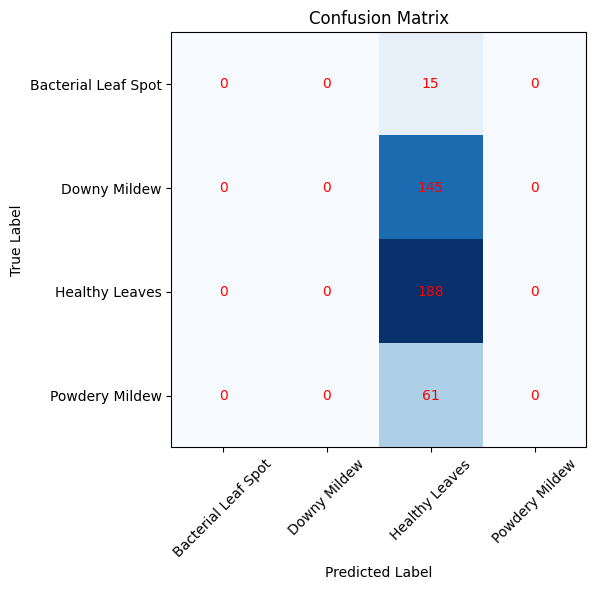

In [41]:
# === Step 5: Load Best Model ===
best_model = load_model('best_resnet50_model.keras')

# === Step 6: Best Epoch Info ===
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = history.history['val_accuracy'][best_epoch - 1]
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# === Step 7: Predict on Test Data ===
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# === Step 8: Metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# === Step 9: Classification Report & Confusion Matrix ===
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(4), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(4), labels=class_labels)
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()


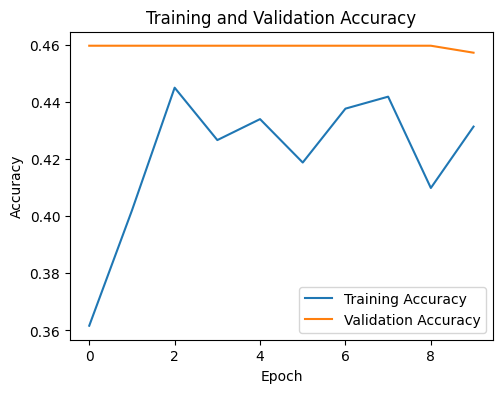

In [42]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

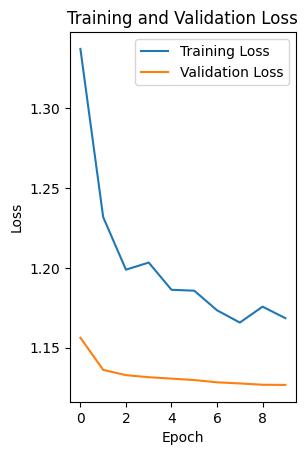

In [43]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Step 1: Paths ===
train_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
val_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
test_path = "/kaggle/input/dataset5/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"

# === Step 2: Data Generators ===
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_aug.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_aug.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1908 images belonging to 4 classes.
Found 409 images belonging to 4 classes.
Found 409 images belonging to 4 classes.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Step 1: Build MobileNetV3 Model ===
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# === Step 2: Compile Model ===
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Step 3: Checkpoint Callback (save best model in .keras format) ===
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# === Step 4: Train Model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint]
)

# === Step 5: Load the Best Model ===
best_model = load_model('best_model.keras')


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.3628 - loss: 1.3336
Epoch 1: val_accuracy improved from -inf to 0.55257, saving model to best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 631ms/step - accuracy: 0.3629 - loss: 1.3332 - val_accuracy: 0.5526 - val_loss: 1.1822
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3945 - loss: 1.2478
Epoch 2: val_accuracy did not improve from 0.55257
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - accuracy: 0.3947 - loss: 1.2476 - val_accuracy: 0.4597 - val_loss: 1.1423
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3805 - loss: 1.2182
Epoch 3: val_accuracy did not improve from 0.55257
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 448ms/step - accuracy: 0.3810 - loss: 1.2180 - val_accuracy: 0.4597 - val_loss: 1.1289
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4402 - loss: 1.1846
Epoch 4: val_accuracy did not improve from 0.55257
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 444ms/step - accuracy: 0.4401 - 

Best Epoch: 1
Best Validation Accuracy: 0.5526


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 549ms/step

Evaluation Metrics:
Accuracy:  0.4670
Precision: 0.2341
Recall:    0.2942
F1-Score:  0.2575

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.00      0.00      0.00        15
       Downy Mildew       0.46      0.70      0.55       145
     Healthy Leaves       0.48      0.47      0.48       188
     Powdery Mildew       0.00      0.00      0.00        61

           accuracy                           0.47       409
          macro avg       0.23      0.29      0.26       409
       weighted avg       0.38      0.47      0.42       409



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


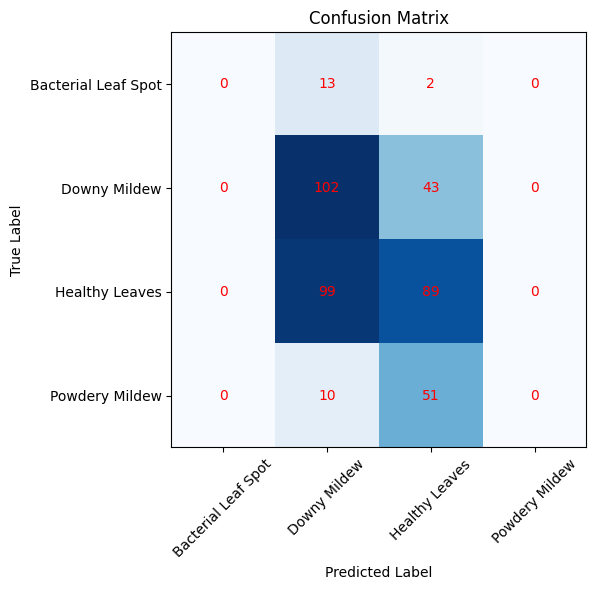

In [37]:
# === Step 6: Get Best Epoch Info ===
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = history.history['val_accuracy'][best_epoch - 1]
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# === Step 7: Predict on Test Data ===
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# === Step 8: Metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# === Step 9: Classification Report & Confusion Matrix ===
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(4), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(4), labels=class_labels)
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()

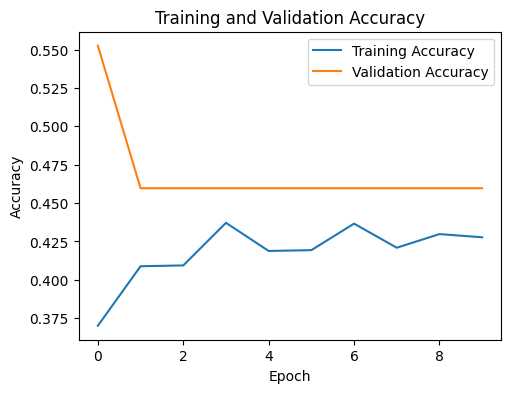

In [38]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

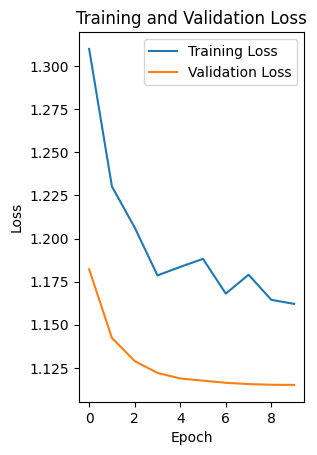

In [39]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()